In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.lines as mlines
matplotlib.rcParams['figure.dpi'] = 360

In [2]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})

palette = sns.color_palette("tab10")
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Download data

In [3]:
import os
import urllib.request
from urllib.parse import urljoin
from bs4 import BeautifulSoup

### EDR

DESI paths *ussually* follow the pattern `/<release>/<type>/redux/<run>/tiles/cumulative/<tileid>/<night>`

- `release`  =  data release (e.g. edr)
- `type `  =  data modality (e.g. spectro)
- `redux`  =  reduction pipeline
- `run`  =  processing campaign name (e.g. fuji)
- `tiles`  =  organizes outputs by tile ID
- `cumulative`  =  coadds accumulated over all exposures
- `tileid`  =  numeric tile identifier
- `night`  =  observation date (YYYYMMDD format)

In [4]:
BASE_URL = 'https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/tiles/cumulative/'

OUT_DIR = './data/fuji/tiles/cumulative/'
os.makedirs(OUT_DIR, exist_ok=True)

In [5]:
def list_links(url):
    resp = urllib.request.urlopen(url)
    soup = BeautifulSoup(resp, 'html.parser')
    return [a['href'] for a in soup.find_all('a', href=True)
            if not a['href'].startswith('?') and a['href'] != '../']

In [6]:
# Get the first tiles
tiles = list_links(BASE_URL)[:3]
print(f'Tiles: {tiles}')

Tiles: ['1/', '10/', '100/']


In [ ]:
for tile_id in tiles:
    tile_url = urljoin(BASE_URL, tile_id)

    night = list_links(tile_url)[0]
    print(f'\n- Tile: {tile_id.rstrip("/")}, night: {night}')

    date_url = urljoin(tile_url, night)
    file_list = list_links(date_url)

    # Create local output directory for this tile and date
    output_dir = os.path.join(OUT_DIR, tile_id.rstrip('/'), night.rstrip('/'))
    os.makedirs(output_dir, exist_ok=True)

    #* Download only files starting with coadd, redrock, or qso
    for filename in file_list:
        if not (filename.startswith("coadd") or filename.startswith("redrock") or filename.startswith("qso")):
            continue

        source_url = urljoin(date_url, filename)
        destination_path = os.path.join(output_dir, filename)

        if os.path.exists(destination_path):
            continue

        print(f'Downloading {filename} ...', end=' ')
        try:
            urllib.request.urlretrieve(source_url, destination_path)
            print('Done!')
        except Exception as e:
            print('Error:', e)

## Read files

In [7]:
tile = tiles[0].rstrip('/')
night = os.listdir(os.path.join(OUT_DIR, tile))[0]
petal = 0

coadd_file = f'{OUT_DIR}{tile}/{night}/coadd-{petal}-{tile}-thru{night}.fits'
redrock_file = f'{OUT_DIR}{tile}/{night}/redrock-{petal}-{tile}-thru{night}.fits'

### Read FITS

In [8]:
from astropy.io import fits
from astropy.table import Table as t

In [9]:
hdu = fits.open(coadd_file)
hdu.info() # Theres different HDUs, we want the FIBERMAP one for general data
           # and FLUX and WAVELENGTH one for spectra

Filename: ./data/fuji/tiles/cumulative/1/20210406/coadd-0-1-thru20210406.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  FIBERMAP      1 BinTableHDU    219   500R x 81C   [K, I, J, K, J, J, D, D, E, E, E, E, K, B, 3A, E, E, J, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, J, I, E, I, I, E, E, E, E, D, E, D, E, E, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     64   1500R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU        11   (2751, 500)   float32   
  5  B_IVAR        1 ImageHDU        11   (2751, 500)   float32   
  6  B_MASK        1 ImageHDU        12   (2751, 500)   int32 (rescales to uint32)   
  7  B_RESOLUTION    1 ImageHDU        11   (2751, 11, 500)   float32   
  8 

In [10]:
with fits.open(coadd_file) as hdu:
    table = t(hdu['FIBERMAP'].data)

table[:5]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,str3,float32,float32,int32,float64,int32,int16,str8,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32
39627817436058850,0,311,311,0,0,149.7272614861328,1.1361875315919674,0.0,0.0,2015.5,5400.0,2162697,1,TGT,78.097435,-285.9366,103200,0.32719911458555384,1,9010,1496p012,338166,5346,DEV,0.026749652,1.6936976,6.080918,18.7367,51.989223,29.48612,264.5119,55.56353,10.075568,1.5687406,0.41309118,0.43432325,1.5593599,4.8047447,0.43432325,1.5593599,4.8047447,0,4.0,1.8740429,0.028569974,-0.25228384,0,,0.0,0.0,0.0,0.0,S,103200,9,2162697,0,0,0,0,0,0,149.7272614861328,1.1361875315919674,1,3,2299.4165,1,1,0.001,0.001,0.004,0.004,149.72726569348964,0.0,1.136172055230268,0.0,0.74082583,78.074,-285.884
39627817440248924,0,272,272,1,512,149.79564127725905,1.1630976592885907,0.0,0.0,2015.5,5400.0,262148,1,TGT,60.97986,-278.79935,103400,0.25874747944555754,1,9010,1498p012,338167,1116,PSF,0.0259326,0.61458087,1.1350796,1.2664398,4.0066347,4.640255,1087.893,454.10437,73.47281,3.0443099,0.6602592,0.47781482,0.8824842,0.98461205,0.47781482,0.8824842,0.98461205,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,S,103400,4,262148,0,0,0,0,0,0,149.79564127725905,1.1630976592885907,1,0,0.0,0,0,-1.08,1.08,-3.898,3.898,149.79114522546985,0.0,1.1782522045948347,0.0,0.0,62.041,-274.845
39627817440251561,0,252,252,2,0,149.9013087937051,1.20924573668924,0.0,0.0,2015.5,5400.0,2162697,1,TGT,34.64572,-266.73514,103200,0.9019615623634148,1,9010,1498p012,338167,3753,REX,0.021372944,0.07182981,0.8169658,4.2794576,27.776167,14.499342,1434.1685,479.87976,74.357285,1.5934578,0.51562095,0.046905,0.53348017,2.7944934,0.08945562,0.73602486,4.843778,0,1.0,0.29541823,0.0,0.0,0,,0.0,0.0,0.0,0.0,S,103200,9,2162697,0,0,0,0,0,0,149.9013087937051,1.20924573668924,1,3,2299.4165,1,1,0.0,0.0,0.002,0.002,149.90130883974766,2.046819e-10,1.2092379456671047,0.0,0.7833043,34.632,-266.682
39627823484241158,0,156,156,3,0,150.05897874058275,1.390858241986411,0.0,0.0,2015.5,5400.0,1441862,1,TGT,-4.432202,-220.39124,103400,0.3855304827905608,1,9010,1501p015,339608,1286,PSF,0.020432826,0.52967143,0.7079924,1.3805336,1.9581124,2.630761,1681.7052,679.724,124.54396,3.1587098,0.66002655,0.41200817,0.5507162,1.0738565,0.41200817,0.5507162,1.0738565,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,S,103400,9,1441862,0,0,0,0,0,0,150.05897874058275,1.390858241986411,1,3,2299.4165,1,1,0.003,0.003,0.005,0.005,150.05899093745177,2.0469662e-10,1.3908384370013198,7.993606e-13,0.789,-4.44,-220.351
39627817444444591,0,198,198,4,0,150.10621596106574,1.2461080452085396,0.0,0.0,2015.5,5400.0,2162697,1,TGT,-16.097828,-257.25854,103200,0.3020414510386

#### Data visualization

##### Coadd files

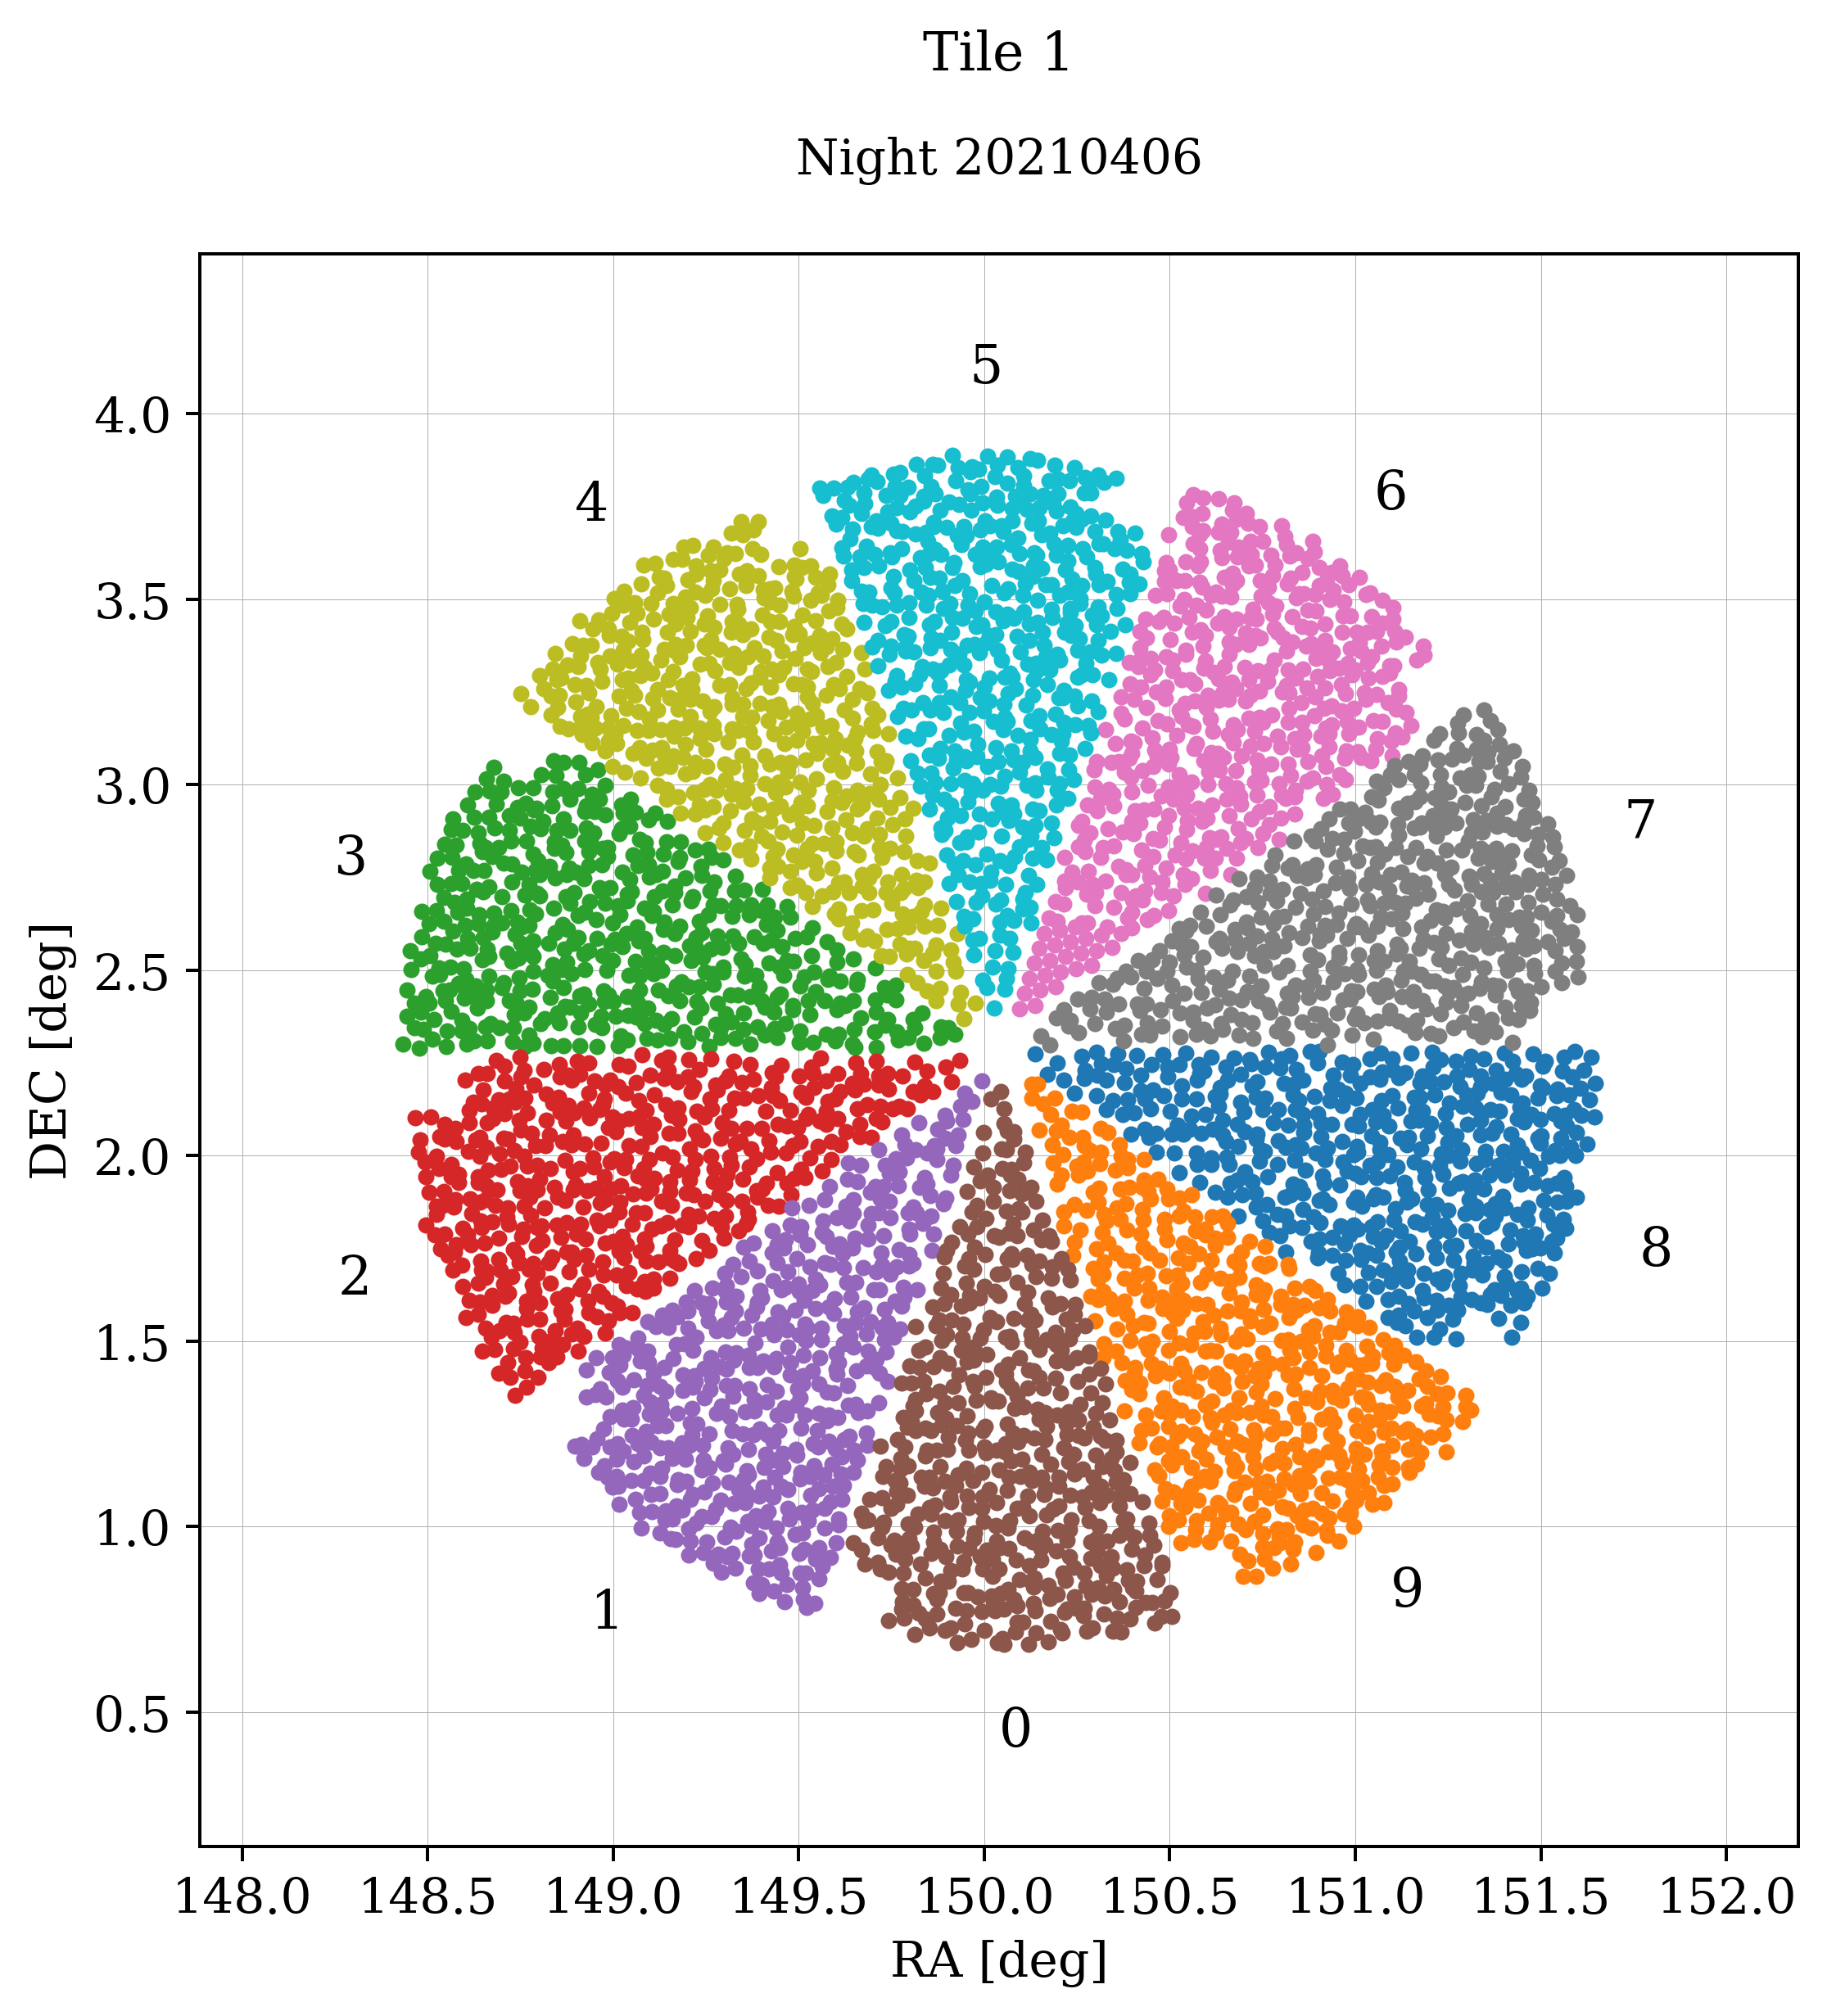

In [11]:
files = [f for f in os.listdir(f'{OUT_DIR}{tile}/{night}') if f.startswith('coadd-')]

fig, ax = plt.subplots(figsize=(7,7))
ax.grid(linewidth=0.2, zorder=0)

for j, petal_file in enumerate(files):

    # Open the FITS file and extract the data
    # Ensure to handle cases where TARGET_RA or TARGET_DEC might not be finite
    # This avoids issues with plotting NaN or infinite values
    data = fits.open(f'{OUT_DIR}{tile}/{night}/{petal_file}')['FIBERMAP'].data
    mask = np.isfinite(data['TARGET_RA']) & np.isfinite(data['TARGET_DEC'])
    data = data[mask]

    ax.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=9, c=[palette[j]],
                zorder=10)

    # Plot petal number
    # Calculate the mean RA and DEC, then find the edge point
    # and place the petal number text at a position offset from the edge
    mean_ra, mean_dec = data['TARGET_RA'].mean(), data['TARGET_DEC'].mean()
    d = np.sqrt((data['TARGET_RA'] - mean_ra)**2 + (data['TARGET_DEC'] - mean_dec)**2)
    edge_ra, edge_dec = data['TARGET_RA'][np.argmax(d)], data['TARGET_DEC'][np.argmax(d)]
    ax.text(mean_ra - 0.8 * (edge_ra - mean_ra), mean_dec - 0.8 * (edge_dec - mean_dec),
            data['PETAL_LOC'][0], fontsize=13, color='black', ha='center', va='center')

ax.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.margins(x=0.17, y=0.17)

ax.set_title(f"Tile {data['TILEID'][0]}", y=1.1, fontdict={'fontsize': 13})
ax.text(0.5, 1.05, f'Night {night}', fontsize=12, ha='center', transform=ax.transAxes)

ax.set_xlabel('RA [deg]'); ax.set_ylabel('DEC [deg]')
plt.tight_layout()
plt.show()

Filter by `COADD_FIBERSTATUS`

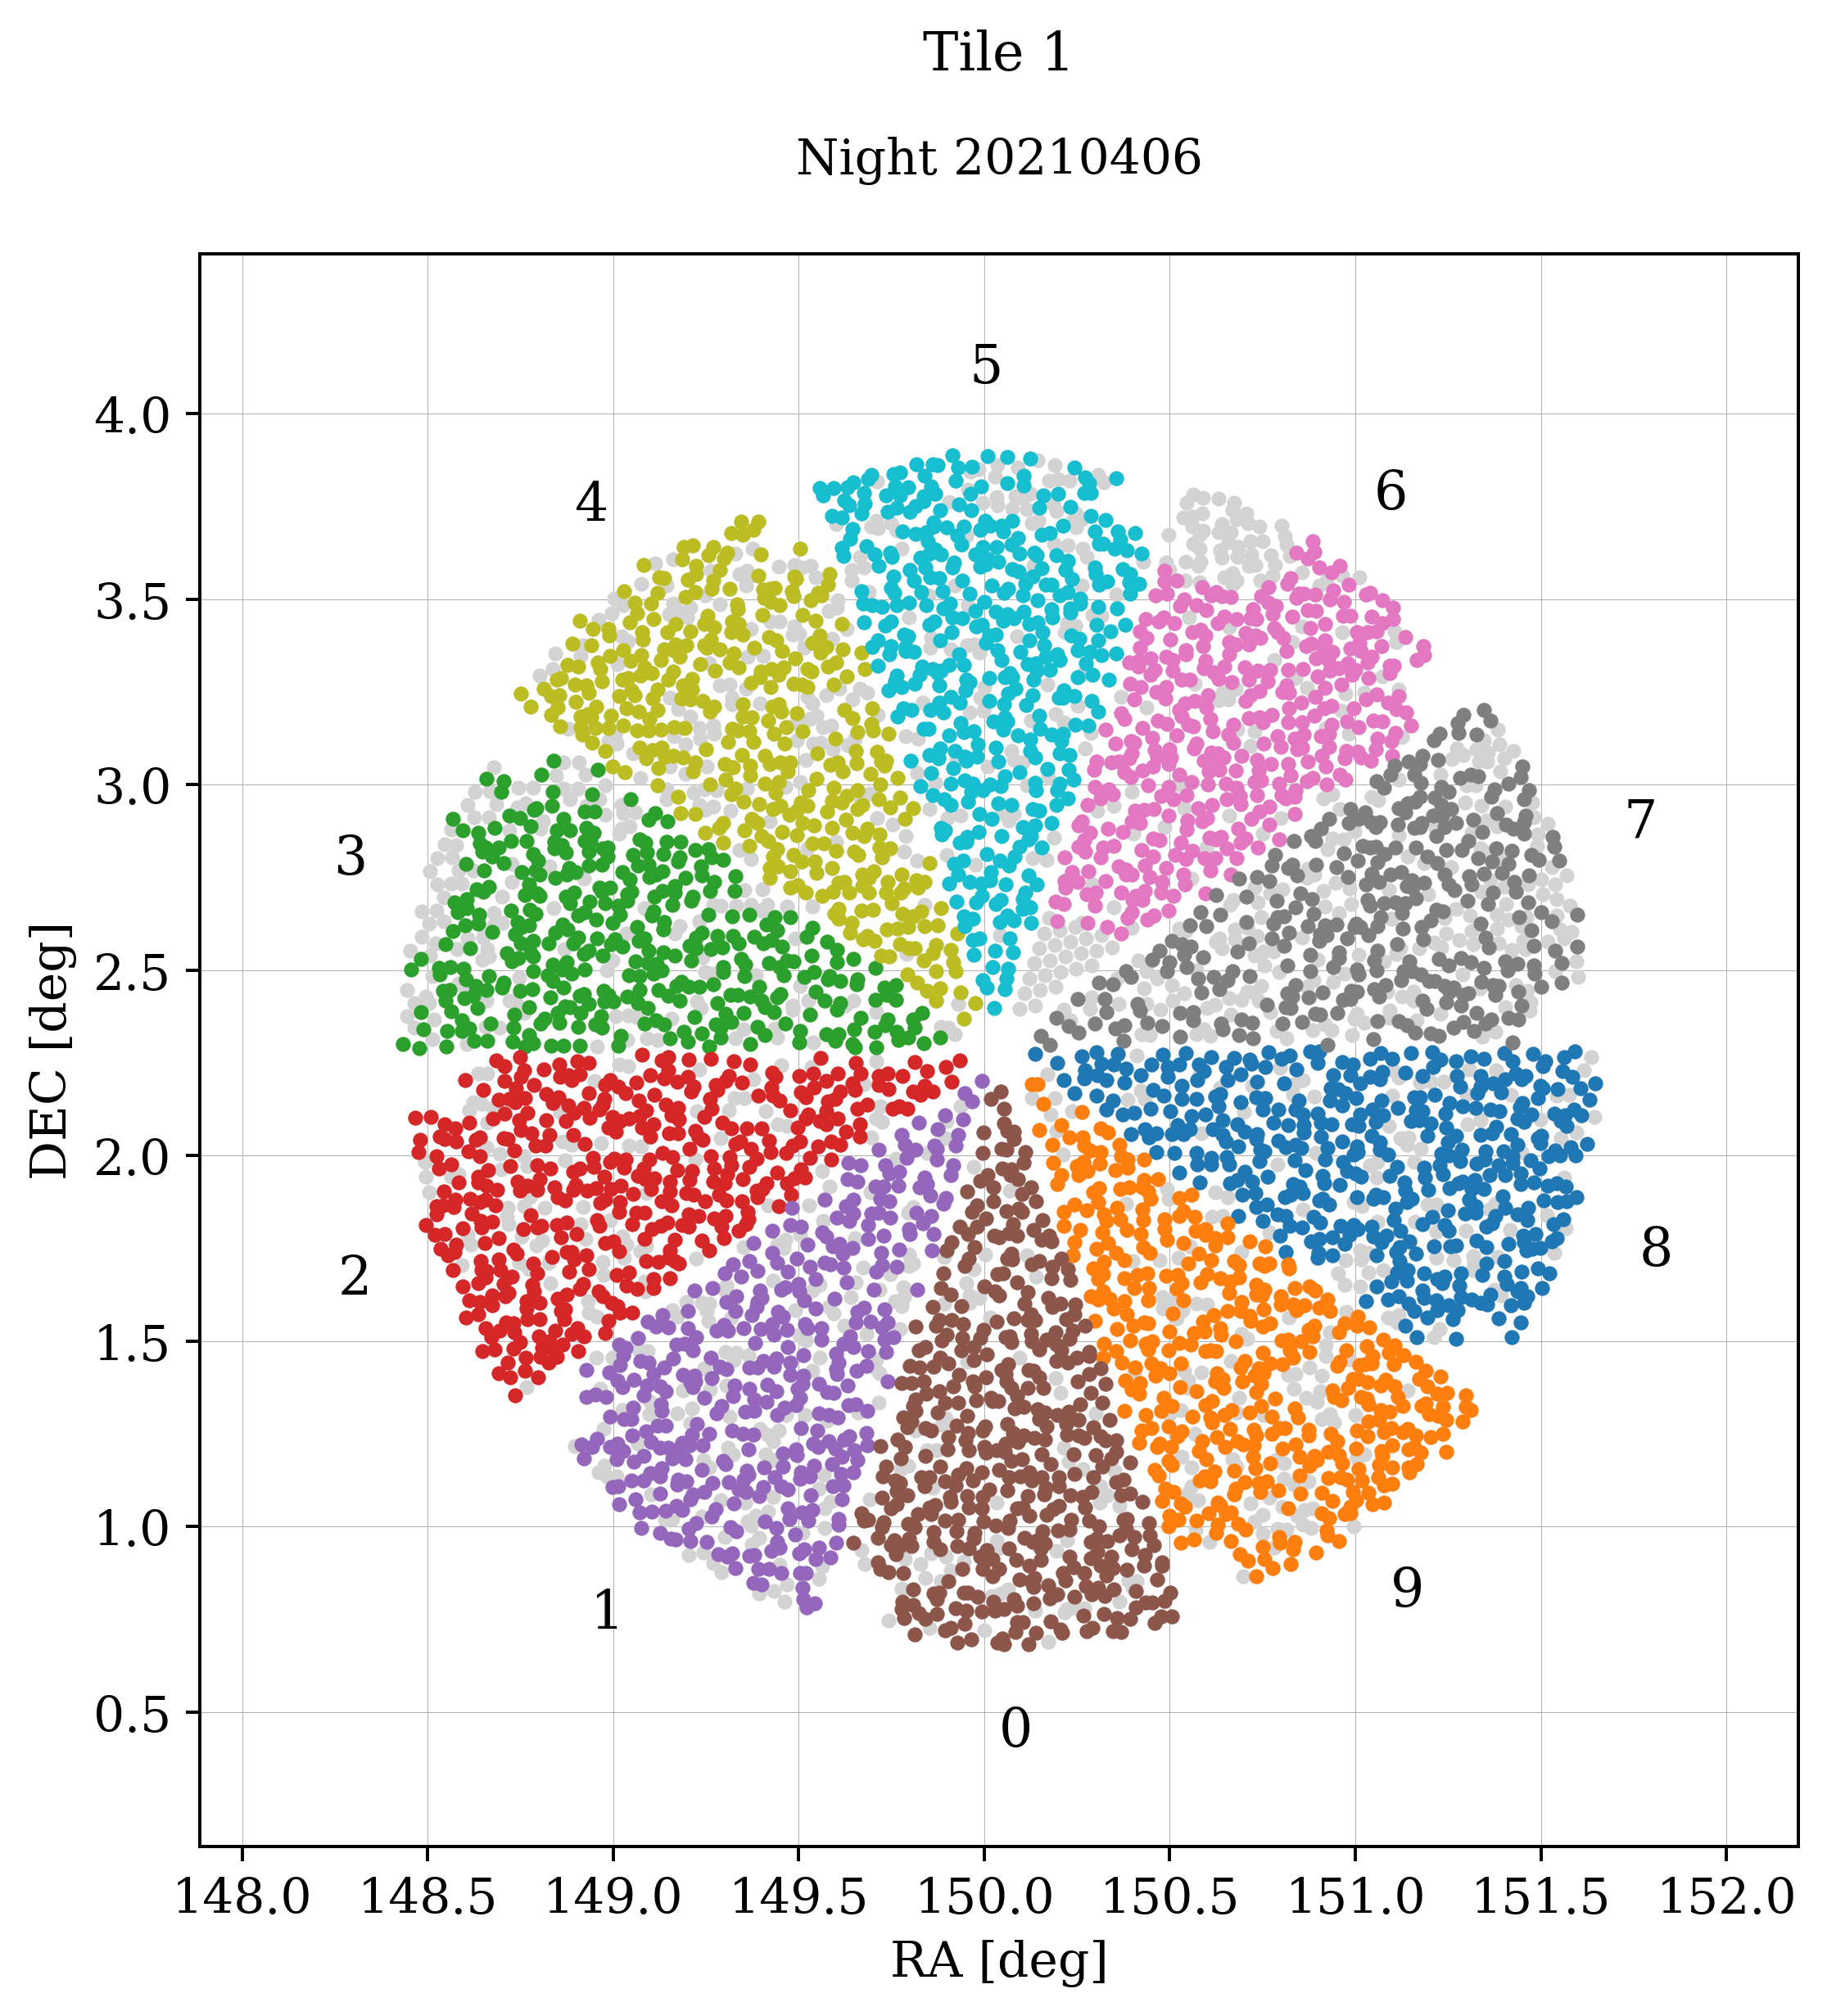

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
ax.grid(linewidth=0.2, zorder=0)

for j, petal_file in enumerate(files):

    data = fits.open(f'{OUT_DIR}{tile}/{night}/{petal_file}')['FIBERMAP'].data
    finite_mask = np.isfinite(data['TARGET_RA']) & np.isfinite(data['TARGET_DEC'])
    data = data[finite_mask]

    # Plot all fibers in light grey
    ax.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=7, c='lightgrey', zorder=5)

    # Only plot valid fibers (with COADD_FIBERSTATUS == 0) in colors
    mask = data['COADD_FIBERSTATUS']==0
    ax.scatter(data[mask]['TARGET_RA'], data[mask]['TARGET_DEC'], s=7, c=[palette[j]],
                zorder=10)

    mean_ra, mean_dec = data['TARGET_RA'].mean(), data['TARGET_DEC'].mean()
    d = np.sqrt((data['TARGET_RA'] - mean_ra)**2 + (data['TARGET_DEC'] - mean_dec)**2)
    edge_ra, edge_dec = data['TARGET_RA'][np.argmax(d)], data['TARGET_DEC'][np.argmax(d)]
    ax.text(mean_ra - 0.8 * (edge_ra - mean_ra), mean_dec - 0.8 * (edge_dec - mean_dec),
            data['PETAL_LOC'][0], fontsize=13, color='black', ha='center', va='center')

ax.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.margins(x=0.17, y=0.17)

ax.set_title(f"Tile {data['TILEID'][0]}", y=1.1, fontdict={'fontsize': 13})
ax.text(0.5, 1.05, f'Night {night}', fontsize=12, ha='center', transform=ax.transAxes)

ax.set_xlabel('RA [deg]'); ax.set_ylabel('DEC [deg]')
plt.tight_layout()
plt.show()

#### Redrock files

In [13]:
with fits.open(redrock_file) as hdu:
    print(hdu.info())  # Check the HDU structure
    table = t(hdu['REDSHIFTS'].data)

table[:5]

Filename: ./data/fuji/tiles/cumulative/1/20210406/redrock-0-1-thru20210406.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      70   ()      
  1  REDSHIFTS     1 BinTableHDU     32   500R x 11C   [K, D, D, K, D, 10D, K, 6A, 20A, K, D]   
  2  FIBERMAP      1 BinTableHDU    171   500R x 81C   [K, I, J, K, J, J, D, D, E, E, E, E, K, B, 3A, E, E, J, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, J, I, E, I, I, E, E, E, E, D, E, D, E, E, E, E]   
  3  EXP_FIBERMAP    1 BinTableHDU     61   1500R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  4  TSNR2         1 BinTableHDU     75   500R x 33C   [K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
None


TARGETID,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2
int64,float64,float64,int64,float64,float64[10],int64,str6,str20,int64,float64
39627817436058850,0.701739061646407,9.32812651995938e-05,0,8819.13700505346,173.9905162934137 .. 3.4597468748766333,7928,GALAXY,,10,579.7768056765199
39627817440248924,-0.0019956912923479522,4.1311493573349107e-48,1570,8.999999999999996e+99,0.0 .. 0.0,0,STAR,CV,3,1.942668892225729e+84
39627817440251561,1.6783993512820177,0.00014795999653602313,0,9122.221021458507,2022.6457643043002 .. 220.0036396196731,7924,GALAXY,,10,31.279282838106155
39627823484241158,1.171463911340329,4.821831887575556e-05,0,8489.099368095398,29.435393629995016 .. -2.340421992901531,7928,GALAXY,,10,121.29146087169647
39627817444444591,0.8614709088800868,0.00018887453746311414,0,8787.664142053574,110.46732330174467 .. 2.9196563996598837,7927,GALAXY,,10,215.88622658327222


## Plot spectra

In [14]:
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

In [15]:
data = fits.open(coadd_file)

In [16]:
b = data['B_FLUX'].data
r = data['R_FLUX'].data
z = data['Z_FLUX'].data
wave_b = data['B_WAVELENGTH'].data
wave_r = data['R_WAVELENGTH'].data
wave_z = data['Z_WAVELENGTH'].data

In [17]:
# Define a Gaussian kernel for smoothing
kernel = Gaussian1DKernel(10)

tgt = 0 # First target in the file
tgt_id = data['FIBERMAP'].data['TARGETID'][tgt]

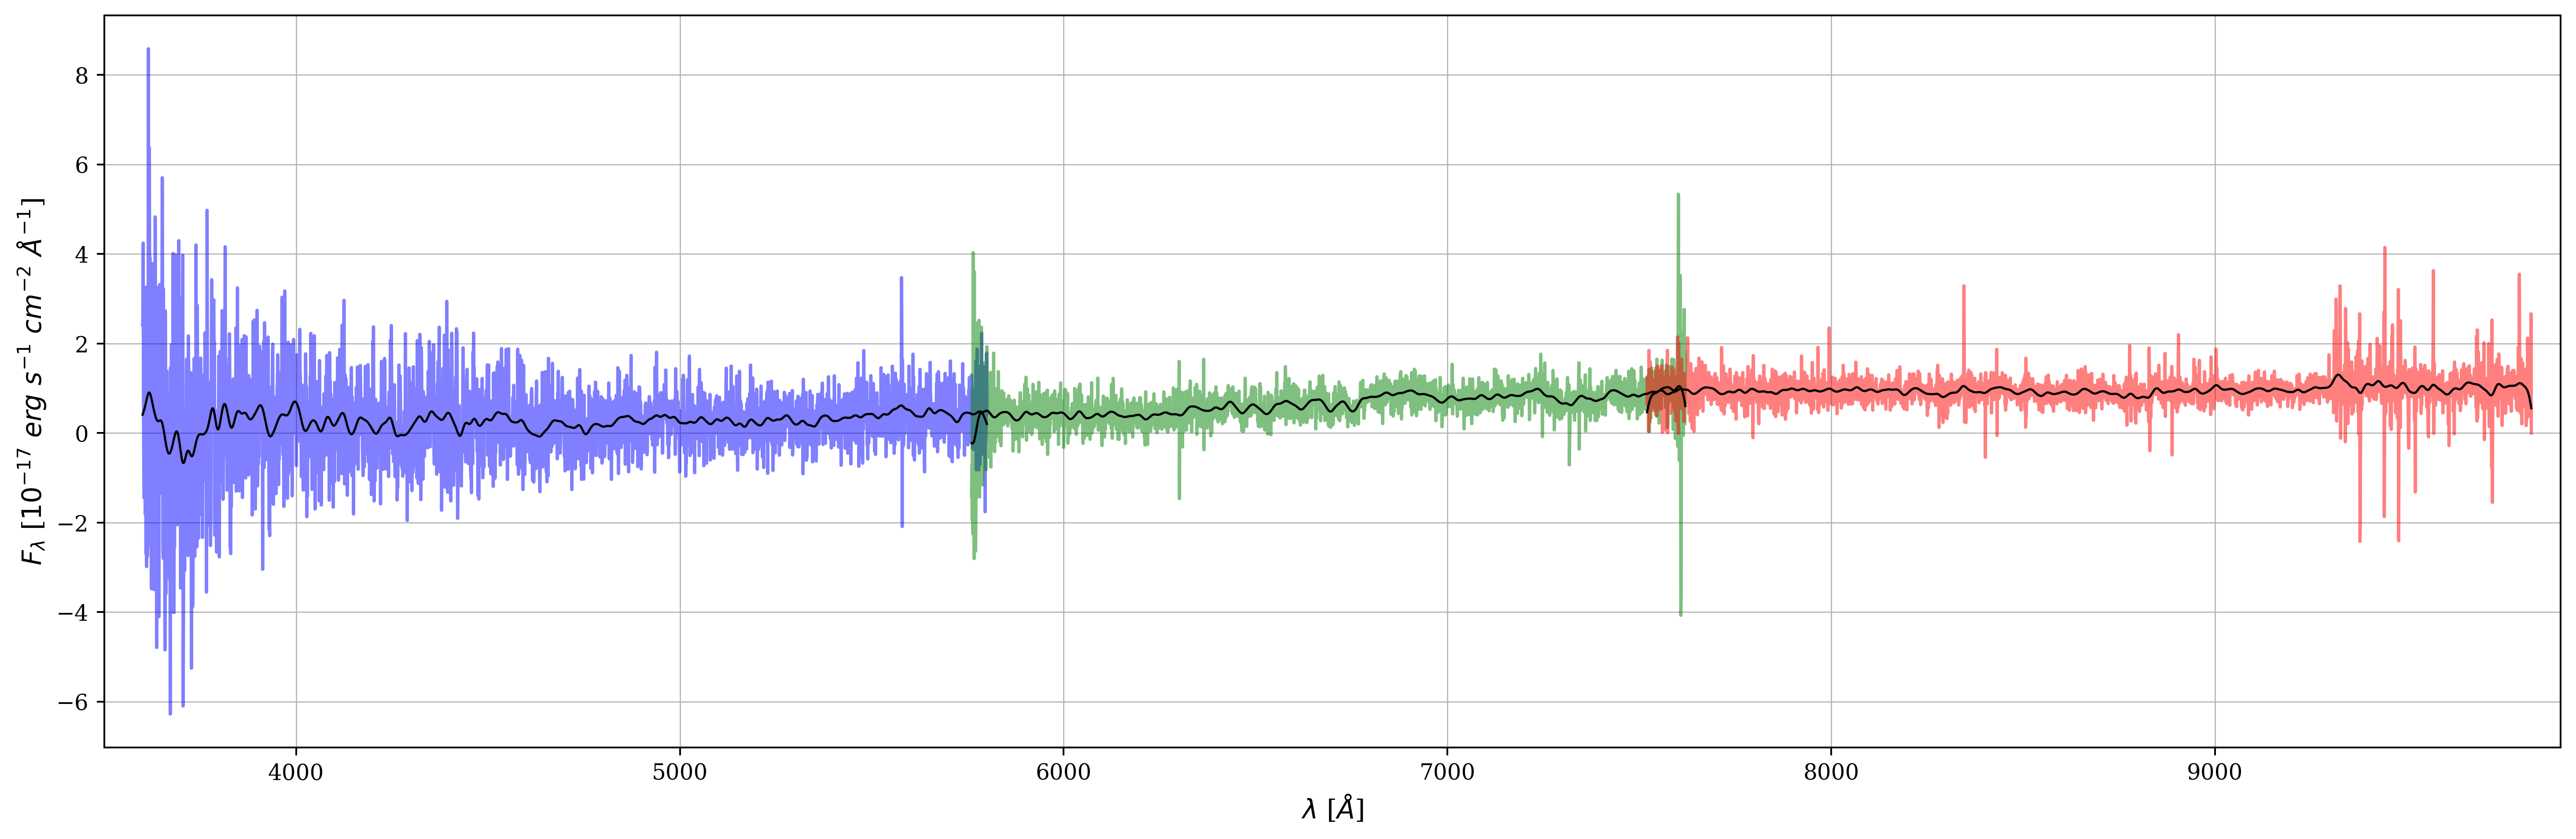

In [18]:
plt.figure(figsize=(20, 6))
plt.grid(linewidth=0.5)

plt.plot(wave_b, b[tgt], color='b', alpha=0.5)
plt.plot(wave_r, r[tgt], color='g', alpha=0.5)
plt.plot(wave_z, z[tgt], color='r', alpha=0.5)

plt.plot(wave_b, convolve(b[tgt], kernel), color='k', linewidth=1.0)
plt.plot(wave_r, convolve(r[tgt], kernel), color='k', linewidth=1.0)
plt.plot(wave_z, convolve(z[tgt], kernel), color='k', linewidth=1.0)

plt.xlim([3500, 9900])
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.ylabel(r'$F_{\lambda}$ [$10^{-17}\ erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

Get information from the redrock file

In [19]:
z_data = fits.open(redrock_file)
with z_data as hdu:
    print(hdu.info())  # Check the HDU structure
    table = t(hdu['REDSHIFTS'].data)

table[:5]

Filename: ./data/fuji/tiles/cumulative/1/20210406/redrock-0-1-thru20210406.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      70   ()      
  1  REDSHIFTS     1 BinTableHDU     32   500R x 11C   [K, D, D, K, D, 10D, K, 6A, 20A, K, D]   
  2  FIBERMAP      1 BinTableHDU    171   500R x 81C   [K, I, J, K, J, J, D, D, E, E, E, E, K, B, 3A, E, E, J, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, J, I, E, I, I, E, E, E, E, D, E, D, E, E, E, E]   
  3  EXP_FIBERMAP    1 BinTableHDU     61   1500R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  4  TSNR2         1 BinTableHDU     75   500R x 33C   [K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
None


TARGETID,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2
int64,float64,float64,int64,float64,float64[10],int64,str6,str20,int64,float64
39627817436058850,0.701739061646407,9.32812651995938e-05,0,8819.13700505346,173.9905162934137 .. 3.4597468748766333,7928,GALAXY,,10,579.7768056765199
39627817440248924,-0.0019956912923479522,4.1311493573349107e-48,1570,8.999999999999996e+99,0.0 .. 0.0,0,STAR,CV,3,1.942668892225729e+84
39627817440251561,1.6783993512820177,0.00014795999653602313,0,9122.221021458507,2022.6457643043002 .. 220.0036396196731,7924,GALAXY,,10,31.279282838106155
39627823484241158,1.171463911340329,4.821831887575556e-05,0,8489.099368095398,29.435393629995016 .. -2.340421992901531,7928,GALAXY,,10,121.29146087169647
39627817444444591,0.8614709088800868,0.00018887453746311414,0,8787.664142053574,110.46732330174467 .. 2.9196563996598837,7927,GALAXY,,10,215.88622658327222


In [20]:
target = table['TARGETID']== tgt_id
z = table['Z'][target][0]
spectype = table['SPECTYPE'][target][0]

In [21]:
print(f'Target ID: {tgt_id}\nRedshift: {z}\nSpectral Type: {spectype}')

Target ID: 39627817436058850
Redshift: 0.701739061646407
Spectral Type: GALAXY


Get data from a specific type (eg., qso)

In [22]:
with fits.open(coadd_file) as hdul:
    fibermap = t(hdul["FIBERMAP"].data)
with fits.open(redrock_file) as hdul:
    redrock = t(hdul["REDSHIFTS"].data)

qso_mask = redrock["SPECTYPE"] == "QSO"
qso_fibermap = fibermap[qso_mask]

In [23]:
qso_mask.shape, len(fibermap), len(redrock)

((500,), 500, 500)

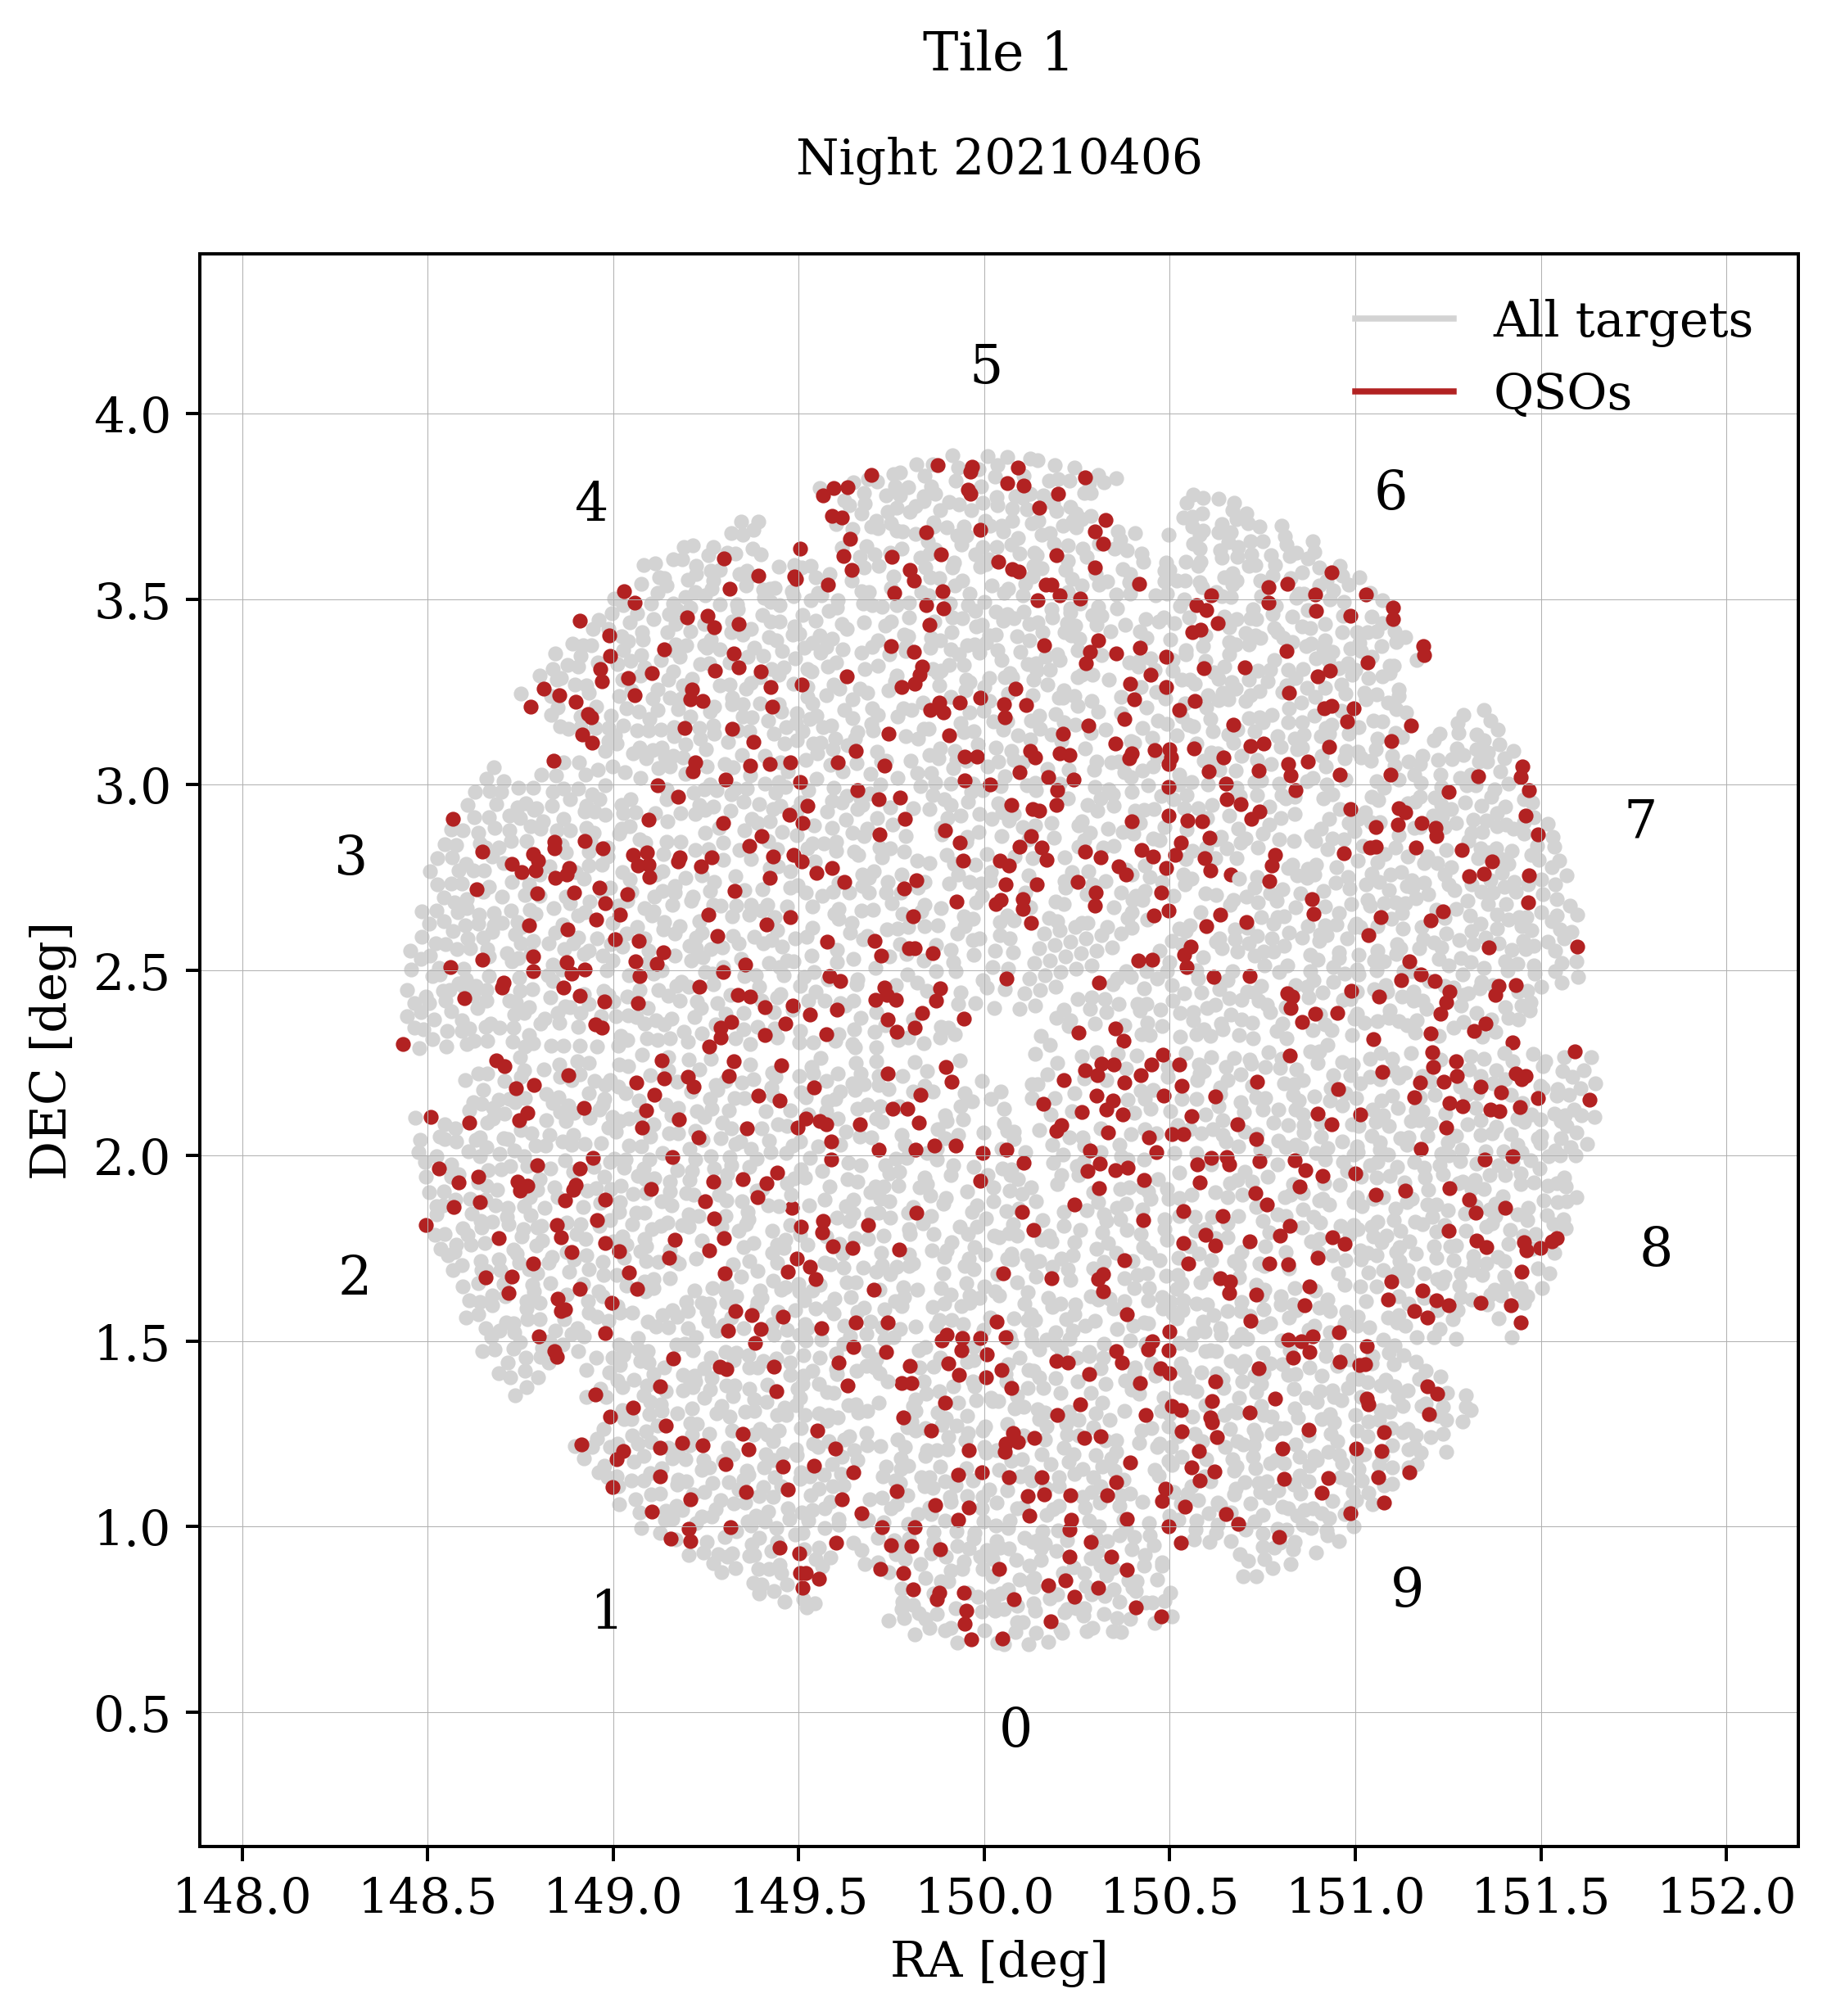

In [24]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(linewidth=0.2, zorder=0)

for petal_id in range(len(files)):

    redrock_path = f'{OUT_DIR}{tile}/{night}/redrock-{petal_id}-{tile}-thru{night}.fits'
    coadd_path = f'{OUT_DIR}{tile}/{night}/coadd-{petal_id}-{tile}-thru{night}.fits'

    with fits.open(coadd_path) as f_coadd, fits.open(redrock_path) as f_red:
        fibermap = t(f_coadd["FIBERMAP"].data)
        redrock = t(f_red["REDSHIFTS"].data)
        qso_mask = redrock["SPECTYPE"] == "QSO"

    # Filter out any non-finite coordinates
    finite = np.isfinite(fibermap['TARGET_RA']) & np.isfinite(fibermap['TARGET_DEC'])
    fibermap = fibermap[finite]
    mask = qso_mask[finite]
    # Plot all targets in light grey
    ax.scatter(fibermap['TARGET_RA'][~mask], fibermap['TARGET_DEC'][~mask],
               s=7, c='lightgrey')

    # Plot just the QSOs in red
    ax.scatter(fibermap['TARGET_RA'][mask], fibermap['TARGET_DEC'][mask],
               s=7, c='firebrick')

    mean_ra  = np.mean(fibermap['TARGET_RA'])
    mean_dec = np.mean(fibermap['TARGET_DEC'])
    d2edge = np.sqrt((fibermap['TARGET_RA'] - mean_ra)**2 +
                     (fibermap['TARGET_DEC'] - mean_dec)**2)
    edge_idx = np.argmax(d2edge)
    edge_ra, edge_dec = fibermap['TARGET_RA'][edge_idx], fibermap['TARGET_DEC'][edge_idx]
    ax.text(mean_ra - 0.8*(edge_ra - mean_ra),
            mean_dec - 0.8*(edge_dec - mean_dec),
            fibermap['PETAL_LOC'][0],
            fontsize=13, color='black',
            ha='center', va='center')

ax.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.margins(x=0.17, y=0.17)

ax.set_title(f"Tile {fibermap['TILEID'][0]}", y=1.1, fontdict={'fontsize': 13})
ax.text(0.5, 1.05, f'Night {night}', fontsize=12,
        ha='center', transform=ax.transAxes)

all_targets = mlines.Line2D([], [], color='lightgrey', label='All targets')
qsos = mlines.Line2D([], [], color='firebrick', label='QSOs')

ax.legend(handles=[all_targets, qsos],
          loc='upper right', frameon=False, fontsize=12)

ax.set_xlabel('RA [deg]')
ax.set_ylabel('DEC [deg]')
plt.tight_layout()
plt.show()